<a href="https://colab.research.google.com/github/Jollyhrothgar/deep_learning/blob/master/Lesson_3_The_Fashion_MNIST_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The Fashion MNIST dataset contains 70,000  images containing 10 different classes of clohting. Each clothing item is represented as a well-centered 28 by 28 grescale picture.

## Data Preparation

Each image is converted to a vector by flattening the image from a 28 $\times$ 28 to a 784 element vector.

The input layer will transform the vector into a densly connected 128 neuron output. This means that we multiply the 784 element vector representing an image with a 784 $\times$ 128 matrix to generate a new transformed vector representing the embedding.

For the activation function for each number, we use the relu function, which is useful in this case. ReLU has some interesting properties which make it useful here:

* When the weighted sum of the neuron is less than 0, we set this to zero, effectively de-activating any subsequent weight associated with this neuron.

There are lots of activation functions, and the properties of these functions tend to be designed to facilitate a few different things:

* Computation constraint when calculating the gradient during back propagation / loss minimization
* Try to solve the "vanishing gradient" problem - e.g., issues that create an ambiguous loss surface.
* Avoid "dead" neurons - e.g. neurons for whom the learned weight is zero

Activation functions can also be used map the final layer of the problem to classification or regression. ReLU should not be used for the final layer of a network - [more information here](https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/#:~:text=The%20ReLU%20function%20is%20another,neurons%20at%20the%20same%20time.)

Output layer for classification should be dense, and have the same number of neurons as there are classes. Additionally, the layer must use softmax activation, which converts the output to a probability.

# Load Libraries!

In [1]:
from __future__ import absolute_import, division, print_function
import math

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


In [2]:
data, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

Shuffling and writing examples to /home/jovyan/tensorflow_datasets/fashion_mnist/3.0.1.incomplete7U1M7X/fashion_mnist-train.tfrecord


Shuffling and writing examples to /home/jovyan/tensorflow_datasets/fashion_mnist/3.0.1.incomplete7U1M7X/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /home/jovyan/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
print(data)
print(metadata)

{'test': <PrefetchDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>, 'train': <PrefetchDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>}
tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollg

Okay - so we now have loaded the data in tensorflow's data format. The data set has encoded the label numerically, so we manually write down the mapping of the numeric label to the index of a human readable label.

In [4]:
labels = ['T-Shirt / Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankleboot']

In [5]:
len(labels)

10

We can use the methods included in the metadata object to look at how our data has been split.

In [6]:
num_test, num_train = metadata.splits['test'].num_examples, metadata.splits['train'].num_examples
print("{} Test, {} Train. Percent Test: {:.2f}%".format(
    num_test,
    num_train,
    100*num_test / (num_test + num_train)
))

10000 Test, 60000 Train. Percent Test: 14.29%


We should normalize the images for learning. First, lets get a sense of the max/min values for each pixel.

In [7]:
# Lazy with iterators
for image, label in data['train'].take(1):
  break

# Explicitly with iterators
image, label = next(iter(data['train']))

[tf.data](https://www.tensorflow.org/guide/data) is a library for pipelining data sets seamlessly into tensorflow - the base dataset object is an iterable - so we can grab it quickly as above, but we can also use iterators

Tensorflow datasets don't seem optimized for simple tasks like looking at one image by a randomly generated index - we have to grab one by iteration.  This tensorflow dataset stores what is essentially a list of tensors that can be converted to numpy arrays for viewing.

In [8]:
type(image)

tensorflow.python.framework.ops.EagerTensor

In [9]:
image[0]

<tf.Tensor: shape=(28, 1), dtype=uint8, numpy=
array([[  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [ 18],
       [ 77],
       [227],
       [227],
       [208],
       [210],
       [225],
       [216],
       [ 85],
       [ 32],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0]], dtype=uint8)>

Interesting - it seems its tensors all the way down - but we've got the first rank tensor here representing the second rank tensor that is one image. All values are stored as type int8, which is an 8 byte integer - when we preprocess in a moment, compressing to the range 0 to 1 will require storing values as float32.

The label is also a tensorflow object:

In [10]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=2>

This tells us that we have a zero-rank tensor (which is just a scalar number, that can be accessed with `label.numpy()`).

In [11]:
print(label.numpy(), labels[label.numpy()])

2 Pullover


We can convert this tensor to a more familiar form like so:

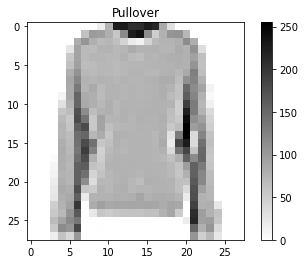

In [14]:
img_matrix = image.numpy().reshape((28,28)) # color dimension is removed.
plt.figure()
plt.imshow(img_matrix, cmap=plt.cm.binary)
plt.colorbar()
plt.title(labels[label.numpy()])
plt.grid(False)

Note a couple of things - first, that the image pixel values vary between 0 and 255 - so we'll need to preprocess the data to compress this range between 0 and 1, so that we're not trying to learn weird scale-stuff with tensorflow. We need to define a function that will normalize to this range, and we build it so that we can apply the normalization to the dataset using tensorflow's map functionality.

# Preprocessing

In [16]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

train_dataset = data['train'].map(normalize)
test_dataset = data['test'].map(normalize)

## Cache the datasets in memory to keep things zippy (not always possible with gigantic datasets.)
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

In [17]:
train_dataset

<CacheDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>

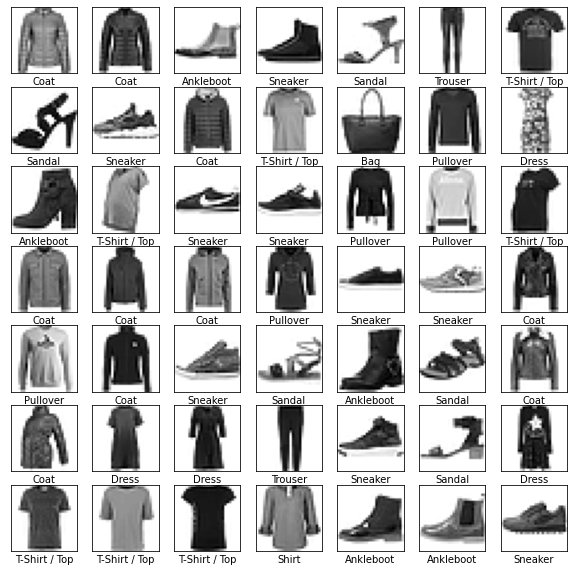

In [18]:
# Look images (50 by 50)
N = 7
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(N * N):
  image = image.numpy().reshape((28,28))
  plt.subplot(N, N, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(labels[label.numpy()])
  i += 1
plt.show()

# Building the Model

Let's build the model!



In [19]:
l_input = tf.keras.layers.Flatten(input_shape=(28, 28, 1))
l_hidden = tf.keras.layers.Dense(128, activation=tf.nn.relu)
l_output = tf.keras.layers.Dense(10, activation=tf.nn.softmax)
model = tf.keras.Sequential([l_input, l_hidden, l_output])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

When training the model below, we specify the batch size which determines how to parallelize the training run. We essentially endlessly cycle through the training set until we've gone through five epochs.

In [20]:
BATCH_SIZE = 32

train_dataset = train_dataset.cache().repeat().shuffle(num_train).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [21]:
history = model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5013 - accuracy: 0.8219
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3731 - accuracy: 0.8654
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3339 - accuracy: 0.8773
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3119 - accuracy: 0.8859
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2958 - accuracy: 0.8900


Text(0.5, 1.0, 'Hidden Layer - Weights')

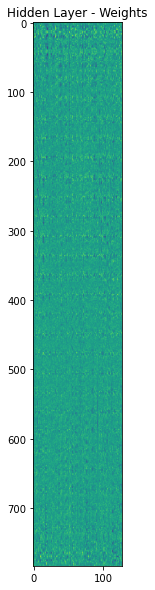

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(l_hidden.weights[0].numpy())
plt.title('Hidden Layer - Weights')

Text(0.5, 1.0, 'Hidden Layer - Biases')

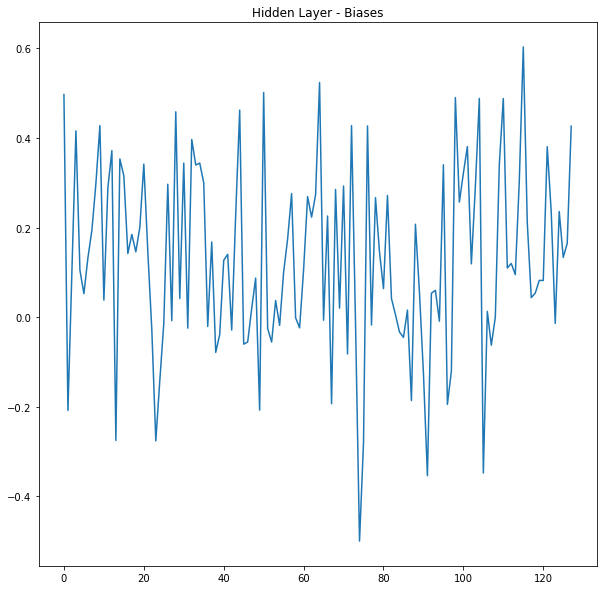

In [23]:
plt.figure(figsize=(10,10))
plt.plot(l_hidden.weights[1].numpy())
plt.title('Hidden Layer - Biases')

Text(0.5, 0, 'Epochs')

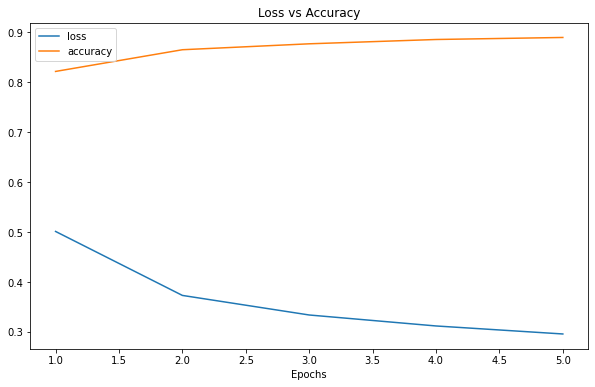

In [24]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(5)+1, history.history['loss'], label='loss')
plt.plot(np.arange(5)+1, history.history['accuracy'], label='accuracy')
plt.legend()
plt.title('Loss vs Accuracy')
plt.xlabel('Epochs')

In [26]:
# Evaluate Loss on Test Set
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 0.3617 - accuracy: 0.8732
Accuracy on test dataset: 0.873199999332428


Pretty good, we have 86(ish).